In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
import quandl 
from pandas_datareader import data as pdr



#### Calcul et affichage du rendement

/Users/julesroche/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


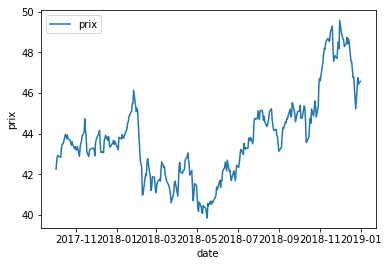

In [2]:

symbol_list = ['ABGB', 'ASTI', 'CSUN', 'DQ', 'FSLR','SPY']
s='SPY'
pepsi=' PEP'
coca='KO'
prices_df =pdr.get_data_yahoo(coca, start="2017-10-01", end="2019-01-01")['Adj Close']
plt.plot(prices_df.index, prices_df.values,label='prix')
plt.xlabel('date')
plt.ylabel('prix')
plt.legend()


p-value = 4.289349512744133e-26 The series Adj Close is likely stationary.


True

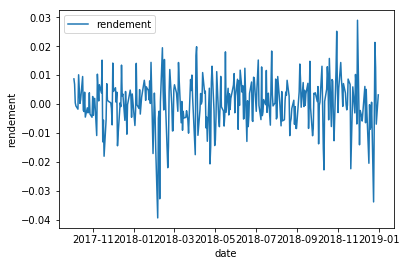

In [3]:
def get_return(Y):
        R = Y.pct_change()[1:]
        return(R)
R_coca=get_return(prices_df)

plt.plot(R_coca,label='rendement')
plt.xlabel('date')
plt.ylabel('rendement')
plt.legend()

def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.') 
        return False
check_for_stationarity(R_coca, cutoff=0.01)

#### Distribution du rendement

/Users/julesroche/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0, 0.5, 'prix')

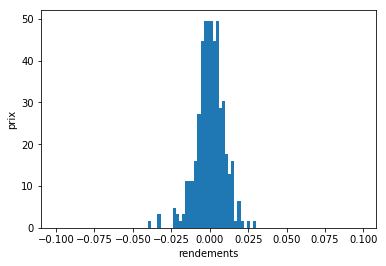

In [5]:
I=[]
l=0.1
N=100
h=(2*l)/N
for i in range(N):
    I.append(-l+i*h)
      

plt.hist(R_coca,normed=True,bins = I)
plt.xlabel('rendements')
plt.ylabel('prix')

In [6]:
from scipy.stats import shapiro

def test_norm(Y):
    level=0.01
    test=shapiro(Y)
    pvalue=test[1]
    if pvalue<level:
        print('pas normalement distribué')
        
    else:
        print('normalement distribué')
    return(pvalue)

test_norm(R_coca)

pas normalement distribué


1.4038509107194841e-05

### Telechargement des données: ne pas executer la cellule suivante

In [ ]:
def get_data_fromweb(all_s,N):
    if all_s:
        l=len(symbol)
    else:
        l=N

    data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    symbol=data['Symbol']
    symbol=list(symbol[1:])
    del symbol[71]
    del symbol[84]
    P=pd.DataFrame(columns=symbol[:l]).fillna(0.0)
 
    k=0
    while (k<l):

        #print(symbol[k])
        try:
            A=pdr.get_data_yahoo(symbol[k], start="2017-10-01", end="2019-01-01")['Adj Close'][:300]
        except:
            k+=1
        k+=1

        P[symbol[k]]=A
    print('done')
    return(P)


#P=get_data_fromweb(0,100)
#P.to_csv('S&Pfinal')
#P_test=P

### Lecture des données: à executer

In [8]:
P=pd.read_csv('S&Pfinal',index_col='Date',parse_dates=True)
P_test=P
P_new=P_test.dropna(axis=1)

### Identification des paires cointégrer: ne pas executer la cellule suivante

In [ ]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i][j] = score
            pvalue_matrix[i][j]  = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    print('done')
    return score_matrix, pvalue_matrix, pairs

#Tab_test=find_cointegrated_pairs(P_new)
#Tab_pair=Tab_test[2]
#Tab_pv=Tab_test[1]
#pvalue=Tab_pv[0]

### Lecture des paires cointégrées


In [9]:
Tab_pair=pd.read_csv('pair_co')
Tab_pair.columns=['0','p1','p2']
del Tab_pair['0']
Tab_pair.head()

,p1,p2
0,ABBV,AES
1,ABBV,AMG
2,ABBV,APTV
3,ABBV,BXP
4,ABMD,ALL


In [10]:
list(Tab_pair.iloc[0])

['ABBV', 'AES']

['ABBV', 'AES']


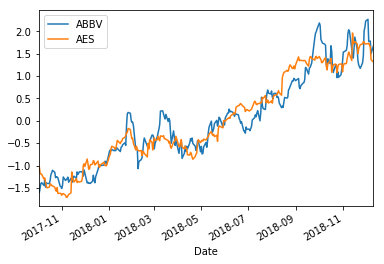

In [11]:
pair=list(Tab_pair.iloc[0])
print(pair)
P_rest=P[pair]
m=P_rest.mean()
s=P_rest.std()
norm=(P_rest-m)/s
norm.plot()



def norm(data):
    m=data.mean()
    sig=data.std()
    return((data-m)/s)

#norm(P_rest).plot()
#plt.plot(norm(P_rest))


### Construction du premier spread

In [14]:
S1=P_rest[pair[0]]
S1_p=S1
S2=P_rest[pair[1]]

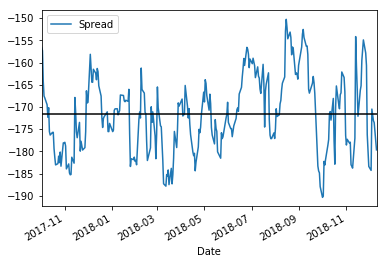

In [15]:

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ABBV']
b = results.params['ABBV']


spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

Text(0, 0.5, 'prix AES')

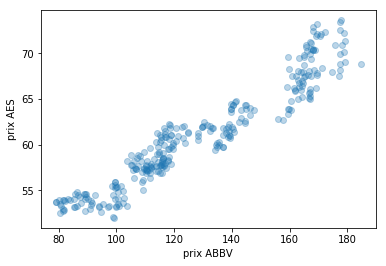

In [16]:
plt.scatter(S2, S1, alpha=0.3)
plt.xlabel('prix ABBV')
plt.ylabel('prix AES')



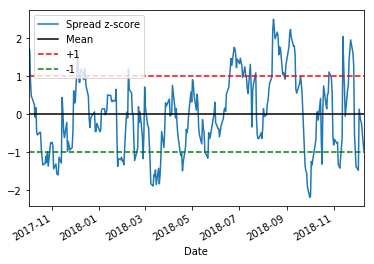

In [17]:
def zscore(series):
    return (series - series.mean()) / np.std(series)
spread_n=zscore(spread)
spread_n.plot()
plt.axhline(spread_n.mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);


### Calcul du rolling Beta

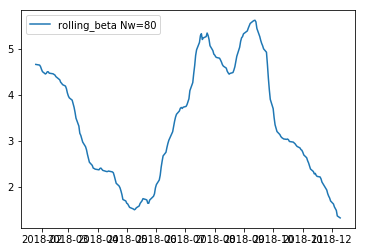

In [19]:
p=80
B=[]
for i in range(p,len(S1)):
    s_1=S1.iloc[i-p:i]
    s_2=S2.iloc[i-p:i]
    s_1 = sm.add_constant(s_1)
    results = sm.OLS(s_2, s_1).fit()
    #s2 a expliquer en fonction de s1 explicative
    b = results.params['ABBV']
    B.append(b)
    
B=pd.DataFrame(B)
#S1=pd.DataFrame(S1)
B.index=S1.iloc[p:].index
P=pd.concat([B,S1.iloc[p:]],axis=1)
P.columns=['beta','prix']
prod=P['beta'].mul(P['beta'])

spread_roll = S2.iloc[p:] - prod
#spread_roll.plot()
#plt.plot(spread_roll,label='rolling spread')

plt.plot(B,label='rolling_beta Nw=80')
plt.legend()
#B.mean()


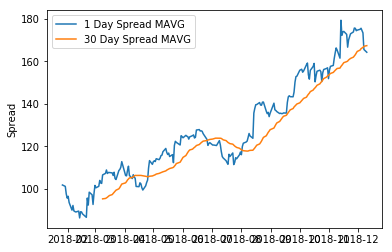

In [20]:
spread_mavg1 =spread_roll.rolling(1).mean()
spread_mavg1.name = 'spread 1d mavg'

# Get the 30 day moving average
spread_mavg30 =spread_roll.rolling(30).mean()
spread_mavg30.name = 'spread 30d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread');

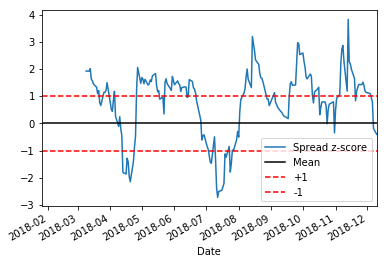

In [21]:
# Take a rolling 30 day standard deviation
std_30 = spread_roll.rolling(30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30

zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--');
plt.axhline(-1.0, color='red', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);


In [22]:
#passer les ordres de trading
#
#zscore_30_1=pd.DataFrame(zscore_30_1)
zscore_30_1=zscore_30_1.dropna(axis=0)
zscore_30_1.name='zscore'
#z=np.array(zscore_30_1)
check_for_stationarity(zscore_30_1, cutoff=0.01)

p-value = 0.04554642851774102 The series zscore is likely non-stationary.


False

### Construction signal de trading

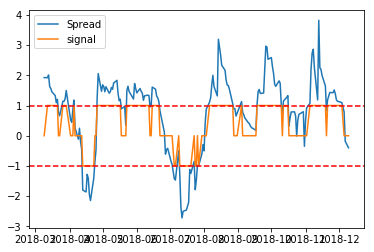

In [23]:
#signal de trading

signal=[0]*len(zscore_30_1)
buy_s=[0]*len(zscore_30_1)
sell_s=[0]*len(zscore_30_1)
for i in range(1,len(zscore_30_1)):
    if zscore_30_1.iloc[i]>1:
        buy_s[i]=1
        signal[i]=1
    elif zscore_30_1.iloc[i]<-1:
        signal[i]=-1
        sell_s[i]=1
#signal=np.array(buy_s)-np.array(sell_s)
buy_s_df=pd.DataFrame(buy_s)
sell_s_df=pd.DataFrame(sell_s)
signal_df=pd.DataFrame(signal)
signal_df.index=zscore_30_1.index
buy_s_df.index=zscore_30_1.index
sell_s_df.index=zscore_30_1.index


plt.plot(zscore_30_1)
plt.plot(signal_df)
plt.axhline(1.0, color='red', linestyle='--');
plt.axhline(-1.0, color='red', linestyle='--')
plt.legend(['Spread', 'signal']);


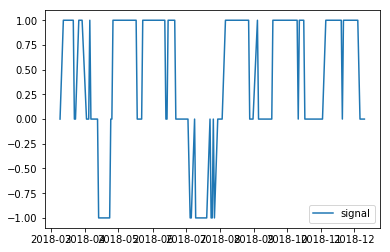

In [24]:
#plt.plot(buy_s_df)
#plt.plot(sell_s_df)
plt.plot(signal_df)
#plt.legend(['buy signal', 'sell signal','signal']);
plt.legend(['signal'])

### Execution de la stratégie

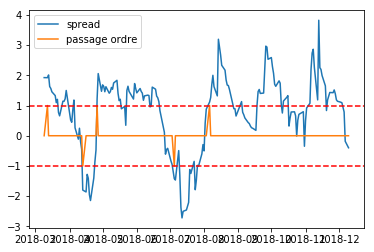

In [25]:
N=len(zscore_30_1)
B_z=B.iloc[len(B)-len(zscore_30_1):]
P=[0]*N
q_x=[0]*N
q_y=[0]*N
position=0
trade_size=100
prev_quantity=0
for i in range(1,N):
    if signal[i]==1:
        if position==0:
            #buy the spread
            prev_quantity=float(B_z.iloc[i])*trade_size
            q_x[i]=(-prev_quantity)
            q_y[i]=(trade_size)
            position=1
            P[i]=position
        elif position==-1:
            q_x[i]=(-float(B_z.iloc[i])*trade_size+prev_quantity)
            prev_quantity=float(B_z.iloc[i])*trade_size
            q_y[i]=(2*trade_size)
            position=1
            P[i]=(position)
            
    elif signal[i]==-1:
        if position==0:
            #buy the spread
            prev_quantity=float(B_z.iloc[i])*trade_size
            q_x[i]=(prev_quantity)
            q_y[i]=(-trade_size)
            position=-1
            P.append(position)
            
        elif position==1:
            q_x[i]=(float(B_z.iloc[i])*trade_size+prev_quantity)
            prev_quantity=float(B_z.iloc[i])*trade_size
            q_y[i]=(-2*trade_size)
            position=-1
            P[i]=(position)
            
qq_x=q_x
        
P=pd.DataFrame(P) 
P.index=zscore_30_1.index
        
plt.plot(zscore_30_1)
plt.plot(P)
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='red', linestyle='--')
plt.legend(['spread','passage ordre']);

In [26]:
prix_1=np.array(S1_p)
prix_1=prix_1[len(S1)-len(qq_x):]
prix_2=np.array(S2)
prix_2=prix_2[len(S2)-len(q_y):]

### Calul de la valeur du portefeuille et de son rendement

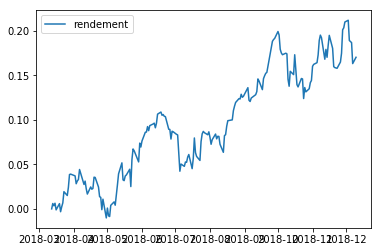

In [27]:
#calcul du P&l
def compute_equity_curve(qty,prix):
    daily_pnl=[]
    cash_buy=[0]*len(qty)
    cash_sell=[0]*len(qty)
    for i in range(len(qty)):
        if (np.sign(qty[i])==1):
            cash_buy[i]=qty[i]*prix[i]
        elif (np.sign(qty[i])==-1):
            cash_sell[i]=-qty[i]*prix[i]
        r=(cash_buy[i]+cash_sell[i])
    #calcul des positions
    pos=np.cumsum(qty)
    abs_pos_dollars=np.abs(prix*pos)
    #print(abs_pos_dollars)

    cum_buy=np.cumsum(cash_buy)
    cum_sell=np.cumsum(cash_sell)
 
    equity=cum_sell-cum_buy+pos*prix
    #r=np.array([equity[i]/abs_pos_dollars[i] for i in range(1,len(equity))])
    #plt.plot(r)
    
 
    return(equity,abs_pos_dollars)

e_2=compute_equity_curve(q_y,prix_2)[0]
abs1=compute_equity_curve(q_y,prix_2)[1]
e_2df=pd.DataFrame(e_2)
#plt.plot(e_2)

e_1=compute_equity_curve(qq_x,prix_1)[0]
abs2=compute_equity_curve(qq_x,prix_1)[1]
e_1df=pd.DataFrame(e_1)
#plt.plot(e_1)

E=e_1+e_2
r=np.array([(e_1[i]+e_2[i])/(abs1+abs2)[i] for i in range(1,len(e_1))])
r_df=pd.DataFrame(r)
r_df.index=zscore_30_1.iloc[1:].index
plt.plot(r_df)
plt.legend(['rendement'])
#print(E)
#E.index=zscore_30_1.index
#E
#plt.plot(E)


### Affichage quantité d'actifs

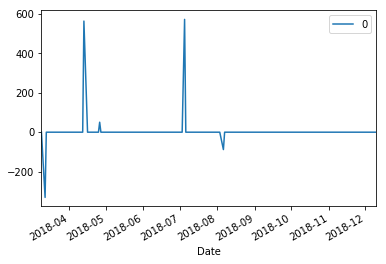

In [30]:
q_x=pd.DataFrame(q_x)
q_x.index=zscore_30_1.index
q_x.plot()

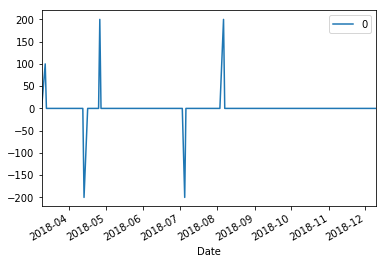

In [31]:

q_y=pd.DataFrame(q_y)
q_y.index=zscore_30_1.index
q_y.plot()

### Calcul des métriques (beta, sharpe ratio)

In [32]:
def sharpe_ratio(Y,rf):
    R=Y
    r=(R.mean()-rf)/R.std()
    print('r',R.mean())
    print('std',R.std())
    return(r)



#sharpe_ratio(r,0)


In [34]:
sp=pdr.get_data_yahoo('SPY', start="2017-12-27", end="2018-12-10")['Adj Close']


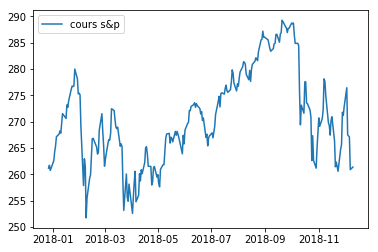

In [35]:
plt.plot(sp,label='cours s&p')
plt.legend()

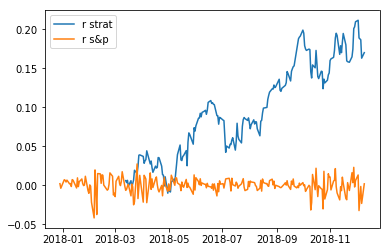

In [39]:
r_sp=get_return(sp)
r_spp=r_sp.iloc[len(sp)-len(zscore_30_1):]
r_sp=pd.DataFrame(r_sp)
r_sp.columns=['sp']
r_df.columns=['strat']
len(r_df)
len(r_spp)
r_df_n=r_df.iloc[1:]

plt.plot(r_df_n)
plt.plot(r_sp)
plt.legend(['r strat','r s&p'])

#r_sp.plot()

### Implémentation filtre de Kalman

In [47]:
from statsmodels import regression
import seaborn
from statsmodels.stats.diagnostic import het_breushpagan
from statsmodels.stats import diagnostic
import statsmodels.stats.diagnostic as smd
import statsmodels.regression as smr
from pykalman import KalmanFilter
from scipy import poly1d

In [ ]:
#implementation filtre de Kalman

#test 1
start = '2012-01-01'
end = '2015-01-01'
y_spy = pdr.get_data_yahoo('SPY', start=start, end=end)['Adj Close']
#x = pdr.get_data_yahoo(coca, start=start, end=end)['Adj Close']

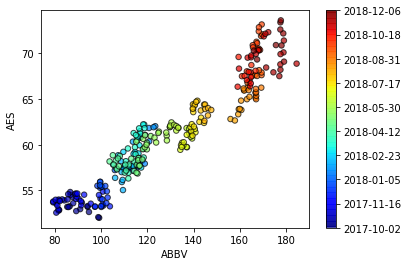

In [48]:
x=S2
y=S1
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(x))
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
plt.xlabel('ABBV')
plt.ylabel('AES');

In [49]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)
state_means, state_covs = kf.filter(y.values)

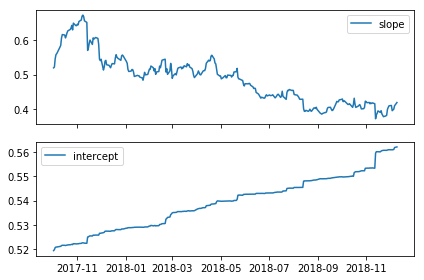

In [50]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();


In [61]:
rolling_b=pd.DataFrame(state_means[:,0])
rolling_b.index=x.index

eps=rolling_b.mul(x,axis=0)
y.columns=['y']
eps.columns=['y']
y=pd.DataFrame(y)
eps=y-eps

eps_n=(eps-eps.mean())/eps.std()
#plt.plot(eps_n)


### Execution de la stratégie à partir des resultats du filtre de kalman

In [62]:
signal=[0]*len(eps)
buy_s=[0]*len(eps)
sell_s=[0]*len(eps)
for i in range(len(eps_n)):
    if list(eps_n.iloc[i])[0]>1:
        buy_s[i]=1
        signal[i]=1
    elif list(eps_n.iloc[i])[0]<-1:
        signal[i]=-1
        sell_s[i]=1

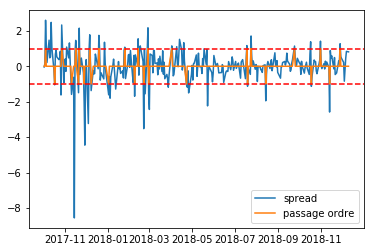

In [63]:
N=len(eps_n)
B_z=rolling_b
P=[0]*N
q_x=[0]*N
q_y=[0]*N
position=0
trade_size=100
prev_quantity=0
for i in range(1,N):
    if signal[i]==1:
        if position==0:
            #buy the spread
            prev_quantity=float(B_z.iloc[i])*trade_size
            q_x[i]=(-prev_quantity)
            q_y[i]=(trade_size)
            position=1
            P[i]=position
        elif position==-1:
            q_x[i]=(-float(B_z.iloc[i])*trade_size+prev_quantity)
            prev_quantity=float(B_z.iloc[i])*trade_size
            q_y[i]=(2*trade_size)
            position=1
            P[i]=(position)
            
    elif signal[i]==-1:
        if position==0:
            #buy the spread
            prev_quantity=float(B_z.iloc[i])*trade_size
            q_x[i]=(prev_quantity)
            q_y[i]=(-trade_size)
            position=-1
            P.append(position)
            
        elif position==1:
            q_x[i]=(float(B_z.iloc[i])*trade_size+prev_quantity)
            prev_quantity=float(B_z.iloc[i])*trade_size
            q_y[i]=(-2*trade_size)
            position=-1
            P[i]=(position)
            
qq_x=q_x
        
P=pd.DataFrame(P) 
P.index=eps_n.index
     
plt.plot(eps_n)
plt.plot(P)
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='red', linestyle='--')
plt.legend(['spread','passage ordre']);
 

In [64]:
prix_1=np.array(x)
prix_2=np.array(y)

In [67]:
def compute_equity_curve(qty,prix):
    daily_pnl=[]
    R=[]
    cash_buy=[0]*len(qty)
    cash_sell=[0]*len(qty)
    for i in range(len(qty)):
        #r_buy=0
        #r_sell=0
        if (np.sign(qty[i])==1):
            cash_buy[i]=qty[i]*float(prix[i])
            
            
        elif (np.sign(qty[i])==-1):
            cash_sell[i]=-qty[i]*float(prix[i])
            
        
    #calcul des positions
    pos=np.cumsum(qty)
    
    #print(abs_pos_dollars)

    cum_buy=np.cumsum(cash_buy)
    cum_sell=np.cumsum(cash_sell)
    #print(cum_buy)
    mul=np.array([pos[i]*float(prix[i]) for i in range(len(pos))])
 
    equity=cum_sell-cum_buy+mul
    abs_pos_dollars=np.abs(mul)
    #print(equity)
    #r=np.array([equity[i]/abs_pos_dollars[i] for i in range(1,len(equity))])
    #plt.plot(r)
    
 
    return(equity,abs_pos_dollars)

e_2=compute_equity_curve(q_y,prix_2)[0]
e_2df=pd.DataFrame(e_2)
#plt.plot(e_2)

e_1=compute_equity_curve(q_x,prix_1)[0]
e_1df=pd.DataFrame(e_1)
#plt.plot(e_1)

E=e_1+e_2
E=pd.DataFrame(E)
E.index=eps_n.index




In [68]:
abs1=compute_equity_curve(q_y,prix_2)[1]
abs2=compute_equity_curve(qq_x,prix_1)[1]

r=np.array([(e_1[i]+e_2[i])/(abs1+abs2)[i] for i in range(len(e_1))])
r_df=pd.DataFrame(r)
r_df.index=eps_n.index
#plt.plot(r_df)
#plt.legend(['rendement'])
#abs1.shape

/Users/julesroche/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


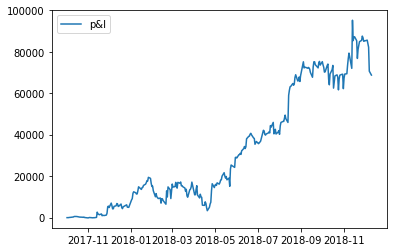

In [69]:
plt.plot(E,label='p&l')
plt.legend()


In [70]:
rd_n=r_df.dropna(axis=0)
rd_n.columns=['return']
type(rd_n['return'])
#sharpe_ratio(rd_n,0)


pandas.core.series.Series

In [71]:
sp=pdr.get_data_yahoo('SPY', start="2017-10-01", end="2019-01-01")['Adj Close'][:300]
r_sp=(get_return(sp))
#np.corrcoef(rd_n, )[0, 1]

In [72]:
r_sp_corr=r_sp.iloc[2:]
rd_n_corr=rd_n.iloc[1:]